# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from joypy import joyplot

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

from tqdm import tqdm
import os
import random

NUM_DATAPOINTS = 100
NUM_SAMPLES = 200
NOISE_STD_DEV = 50

C:\Users\asus\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\asus\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


# Utility functions

In [2]:
def f(x):
    return 2*(x-2)**3 - 3*(x-3)**2 - 4 * x

LATEX_FUNC = "y = 2(x-2)^3-3(x-3)^2-4x"

In [3]:

def plot_true_function(save_path="plots/true_func.png"):
    x = np.linspace(0, 4, 100)
    plt.plot(x, f(x), label=f"${LATEX_FUNC}$")

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('True Function')
    plt.legend()

    plt.grid(True)
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200, transparent=False)
    plt.show()


def generate_data(num_datapoints=NUM_DATAPOINTS, 
                  num_samples=NUM_SAMPLES, 
                  noise_std_dev=NOISE_STD_DEV):
    np.random.seed(42)
    x_values = np.random.choice(np.arange(0,10,0.001), 
                                 size=num_datapoints,
                                 replace=False)

    samples = []
    for i in tqdm(range(num_samples), total=num_samples):
        one_sample_set = []
        for x in x_values:
            y_true = f(x)
            noise = np.random.normal(0, noise_std_dev)
            y_with_noise = y_true + noise
            one_sample_set.append((x, y_with_noise))

        samples.append(np.array(one_sample_set))
    return samples
   

def plot_true_function_with_data(data, 
                                 figsize=(10,6), 
                                 zoom_in=None, 
                                 save_path="plots/true_func_with_data.png"):
    # Plot the true function
    x = data[:, 0]
    y_with_noise = data[:, 1]
    
    x_ = np.linspace(min(x), max(x), 100)
    true_function_values = f(x_)
    
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(x_, true_function_values, label=f'True Function: ${LATEX_FUNC}$', color='blue', linewidth=1)
    ax.scatter(x, y_with_noise, color='red', label='Sample Data with Noise', s=7)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()

    if zoom_in:
        inset_axes_obj = inset_axes(ax, width="30%", height="30%", loc="lower right")
        inset_axes_obj.plot(x_, true_function_values, color='blue', linewidth=1)
        inset_axes_obj.scatter(x, y_with_noise, color='red', s=7)
        inset_axes_obj.set_xlim(zoom_in)
        inset_axes_obj.set_title(f'Zoomed In:{zoom_in}')

    if zoom_in:
        ax.set_title(f'True Function with Sample Data; zoomed in={zoom_in}')
    else:
        ax.set_title('True Function with Sample Data')

    ax.grid(True)
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200, transparent=False)
    plt.show()

    
def plot_y_distributions_across_samples(samples, 
                                        label="$y_i$", 
                                        title="$Y_i$ distributions for each $x_i$",
                                        save_path="plots/true_y_ridgeplot.png"):
    X_cum = []
    y_cum = []

    for i in range(samples.shape[1]):
        X_cum.extend([round(k,2) for k in list(samples[:,i,0])])
        y_cum.extend(list(samples[:,i,1]))

    df = pd.DataFrame({"X":X_cum,"y":y_cum})
    plot = joyplot(df, 
                by = 'X', 
                column = 'y', 
                grid=True, 
                range_style='own', 
                linewidth=1,
                figsize=(10,10),
                title=title,
                colormap=cm.viridis)

    plt.xlabel(label)
    plt.ylabel("$x_i$")
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200, transparent=False)

    plt.show()
    
    return plot
    


def plot_y_with_gx_distributions_across_samples(samples, predictions, title="$Y_i$ and $g(x_i)$ distributions for each $x_i$",
                                               save_path=None):
    
    X_cum = []
    y_cum = []
    pred_cum = []

    for i in range(samples.shape[1]):
        X_cum.extend([round(k,2) for k in list(samples[:,i,0])])
        y_cum.extend(list(samples[:,i,1]))
        pred_cum.extend(list(predictions[:,i,1]))
        
    df = pd.DataFrame({"X":X_cum,"y":y_cum,"g(x)":pred_cum})  
    plot = joyplot(df, 
                by = 'X', 
                column = ["y","g(x)"],
                legend = True,
                grid=True, 
                range_style='own', 
                linewidth=1,
                figsize=(10,10),
                title=title)

    plt.ylabel("$x_i$")
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200, transparent=False)
    plt.show()
    
    return plot


    
def plot_regression_lines(datasets, models, limit=5, 
                          figsize=(10,6), featurizer=None, colors = None,
                          save_path="plots/regression_lines.png"):
    plt.figure(figsize=figsize)
    
    # Plot regression lines
    X_range = np.linspace(min(datasets[0][:, 0]), 
                          max(datasets[0][:, 0]), 
                          num=100).reshape(-1, 1)
    
    true_function_values = f(X_range)
    plt.plot(X_range, true_function_values, label=f'True Function: ${LATEX_FUNC}$', 
             color='green', linewidth=2, linestyle="--")
    
    if featurizer:
        X_range_transformed = featurizer.transform(X_range)
    
        for i in range(len(models)):
            if limit > 0:
                y_pred = models[i].predict(X_range_transformed)
                plt.plot(X_range, y_pred, color="blue", linewidth=1)
                plt.scatter(datasets[i][:,0], datasets[i][:,1], 
                            color=colors[i], label=f'Sample Dataset {i+1}', s=7, alpha=0.5)
            limit -= 1
    else:
        for i in range(len(models)):
            if limit > 0:
                y_pred = models[i].predict(X_range)
                plt.plot(X_range, y_pred, color="blue", linewidth=1)
                plt.scatter(datasets[i][:,0], datasets[i][:,1], 
                            color=colors[i], label=f'Sample Dataset {i+1}', s=7, alpha=0.5)
            limit -= 1
    
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Regression Lines')
    plt.legend()
    plt.grid(True)
    
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200, transparent=False)
        
    plt.show()

# Creating Data


Lets first assume the true function, $$y=f(x) + \epsilon = 2x + 3 + \epsilon$$ where $\epsilon$ is the irreducible error

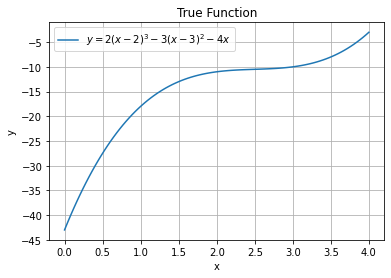

In [4]:
plot_true_function()

Now lets create 200 sample datasets for randomly sampled 100 x from {-100, -99, ..., +99, +100}

In [5]:
# Set a seed for reproducibility
samples = generate_data()

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2192.64it/s]


Visualizing one sample dataset with the true functional values ...

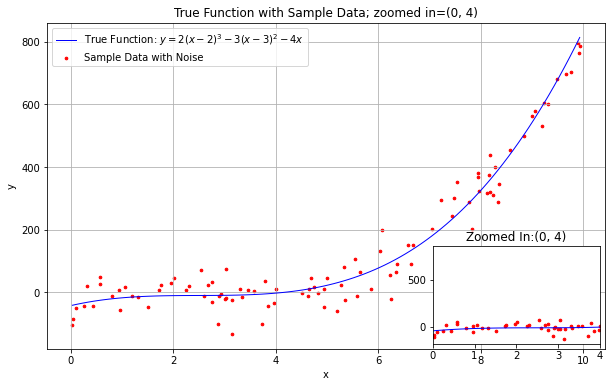

In [6]:
plot_true_function_with_data(samples[10], zoom_in=(0, 4))

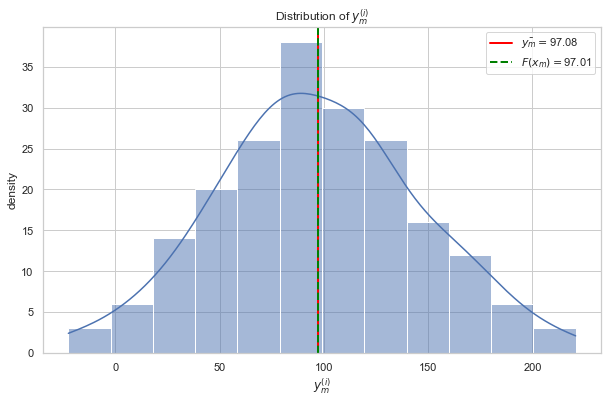

In [7]:
import seaborn as sns
sns.set(style="whitegrid")  # Setting the background style

plt.figure(figsize=(10,6))
# Plotting the distribution
sns.histplot(np.array(samples)[:, 0, 1], kde=True)
mean_value = np.mean(np.array(samples)[:, 0, 1])
true_value = f(np.array(samples)[0, 0, 0])

# Adding a vertical line at the mean
plt.axvline(mean_value, color='red', linewidth=2, label=r'$\bar{y_m}=$'+str(round(mean_value, 2)))
plt.axvline(true_value, color='green', linestyle="dashed", linewidth=2, label=r"$F(x_m)=$"+str(round(true_value, 2)))

# Adding a label to the vertical line
# ax.text(mean_value + 0.02, 3, r'$F(x_m)$', color='red')

# Adding labels and title
plt.title("Distribution of $y^{(i)}_m$")
plt.xlabel("$y^{(i)}_m$")
plt.ylabel("density")
plt.legend()
plt.savefig("plots/y_dist_for_given_x.png", dpi=200, transparent=False)
# Display the plot
plt.show()

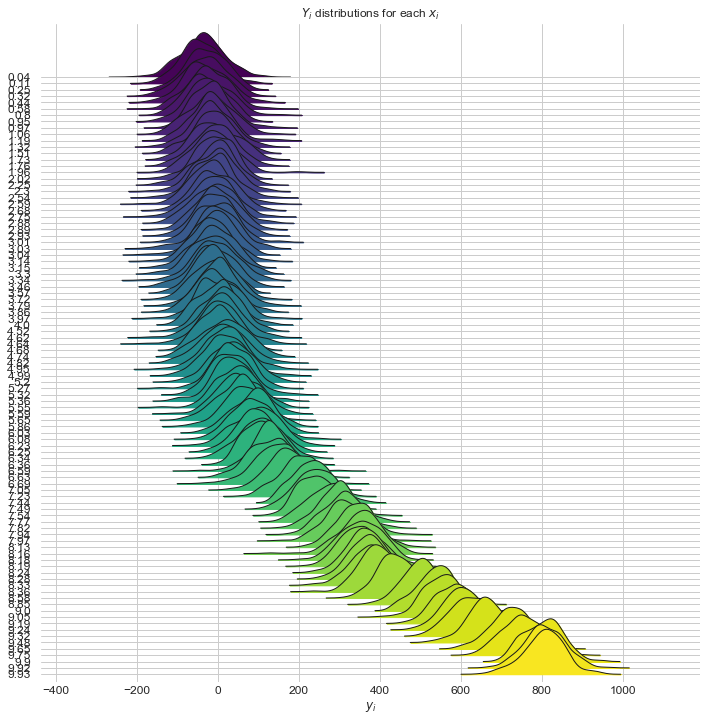

In [8]:
plot = plot_y_distributions_across_samples(np.array(samples))

In [9]:
train_data_size = 0.8

indices = list(range(NUM_DATAPOINTS))
random.shuffle(indices)
split_idx = int(NUM_DATAPOINTS*train_data_size)
train_indices = indices[:split_idx]
test_indices = indices[split_idx:]

train_samples = []
test_samples = []
for sample in samples:
    train_samples.append(sample[train_indices,:])
    test_samples.append(sample[test_indices,:])


# Modelling

## Linear Regression

In [10]:
train_samples[0][0:10,:]

array([[  3.039     ,  17.80110118],
       [  1.76      , -66.41639165],
       [  1.731     , 126.33224882],
       [  8.158     , 323.87680853],
       [  7.438     , 248.64672961],
       [  3.787     , -38.44076804],
       [  6.59      , 142.38297105],
       [  2.678     ,  23.63202959],
       [  9.238     , 510.13163545],
       [  5.589     ,  94.70984627]])

In [11]:

models = []

for data in tqdm(train_samples, total=len(samples)):
    X = data[:,0].reshape(-1,1)
    y = data[:,1].reshape(-1,1)

    # Train the linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    models.append(model)

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1210.56it/s]


In [12]:
train_predictions_across_samples = []
test_predictions_across_samples = []

for data,model in tqdm(zip(train_samples,models), total=len(samples)):
    predictions = model.predict(data[:,0].reshape(-1,1))
    train_predictions_across_samples.append(predictions.reshape(-1,))
    
for data,model in tqdm(zip(test_samples,models), total=len(samples)):
    predictions = model.predict(data[:,0].reshape(-1,1))
    test_predictions_across_samples.append(predictions.reshape(-1,))

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7793.28it/s]


In [13]:
g_bars = np.sum(np.array(test_predictions_across_samples), axis=0)/NUM_SAMPLES
y_bars = np.sum(np.array(test_samples)[:,:,1], axis=0)/NUM_SAMPLES

bias_squared_for_each_xi = (y_bars - g_bars)**2
bias_squared = np.sum(bias_squared_for_each_xi)/NUM_DATAPOINTS

print("Bias of the hypothesis function : ", round(np.sqrt(bias_squared),2))

Bias of the hypothesis function :  43.94


In [14]:
g_bars = np.sum(np.array(test_predictions_across_samples), axis=0)/NUM_SAMPLES
distances = (np.array(test_predictions_across_samples) - g_bars)**2

var_for_each_xi = np.sum(distances, axis=0)/NUM_SAMPLES
variance = np.sum(var_for_each_xi)/NUM_DATAPOINTS

print("Variance of the hypothesis function : ", round(variance,2))

Variance of the hypothesis function :  11.38


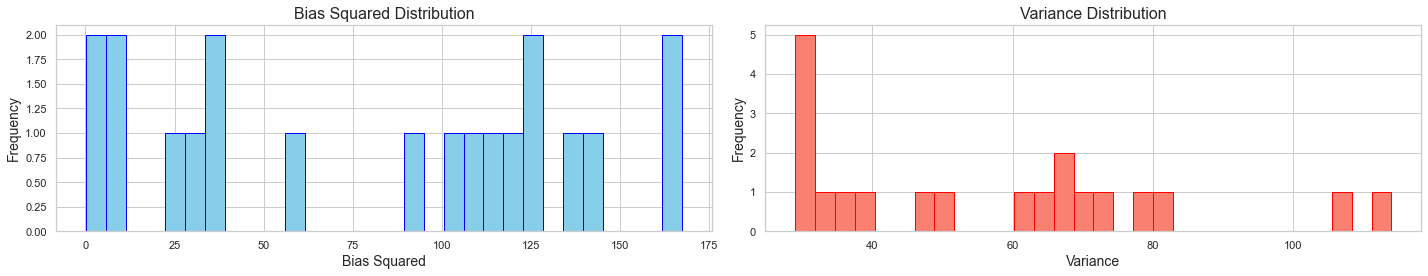

In [15]:
plt.figure(figsize=(20,4))

# Plot the first histogram
plt.subplot(121)
plt.hist(np.sqrt(bias_squared_for_each_xi), bins=30, color='skyblue', edgecolor="blue")
plt.title('Bias Squared Distribution', fontsize=16)
plt.xlabel('Bias Squared', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)

# Plot the second histogram
plt.subplot(122)
plt.hist(var_for_each_xi, bins=30, color='salmon', edgecolor="red")
plt.title('Variance Distribution', fontsize=16)
plt.xlabel('Variance', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)

# Adjust layout spacing
plt.tight_layout()

# Show the plot
plt.savefig("plots/bias_variance_underfit.png", dpi=200, transparent=False)
plt.show()

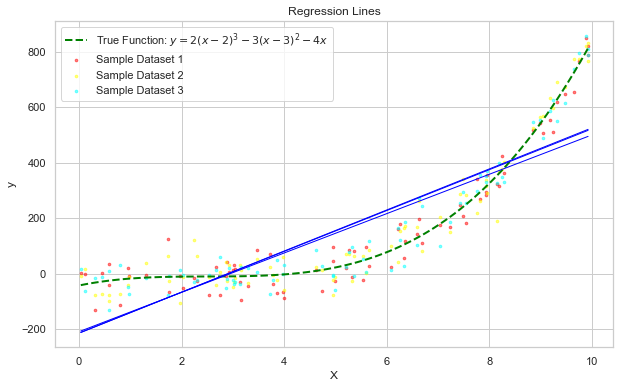

In [16]:
plot_regression_lines(train_samples, models, limit=3, colors=["red", "yellow", "cyan"], 
                      save_path="plots/train_lin_reg_lines.png")

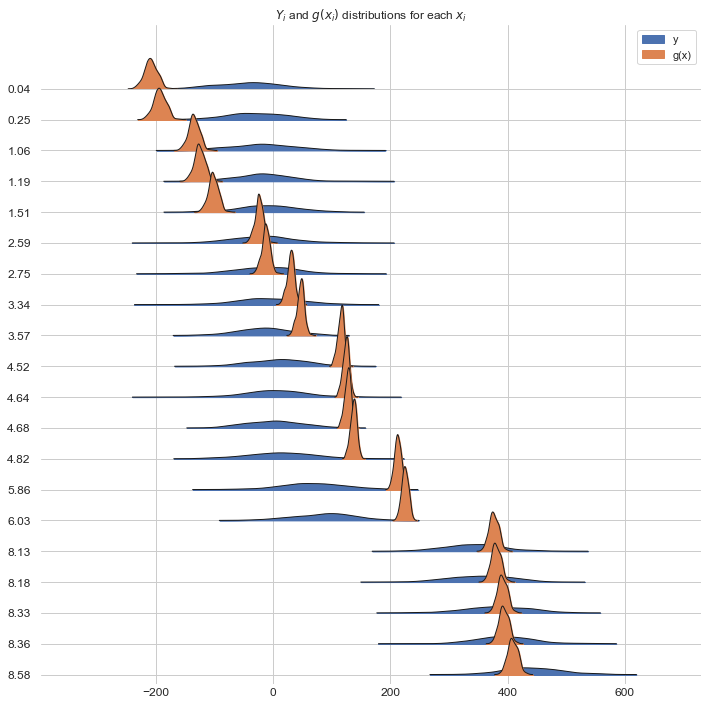

In [17]:
x_matrix = np.expand_dims(np.array(test_samples)[:,:,0], axis=2)
prediction_matrix = np.expand_dims(np.array(test_predictions_across_samples), axis=2)

result_matrix = np.concatenate((x_matrix, prediction_matrix), axis=2)

plot = plot_y_with_gx_distributions_across_samples(np.array(test_samples), result_matrix,
                                                  save_path="plots/lin_reg_ridgeplot.png")

## Polynomial Regression

In [18]:
degree = 30

In [19]:

models = []

for data in tqdm(train_samples, total=len(train_samples)):
    X = data[:,0].reshape(-1,1)
    y = data[:,1].reshape(-1,1)
    
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X)
    
    # Train the linear regression model
    model = LinearRegression()
    model.fit(X_poly, y)
    
    models.append(model)

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 701.72it/s]


In [20]:
train_predictions_across_samples = []
test_predictions_across_samples = []

for data,model in tqdm(zip(train_samples,models), total=len(train_samples)):
    x = data[:,0].reshape(-1,1)
    x_poly = poly_features.transform(x)
    predictions = model.predict(x_poly)
    train_predictions_across_samples.append(predictions.reshape(-1,))
    
for data,model in tqdm(zip(test_samples,models), total=len(test_samples)):
    x = data[:,0].reshape(-1,1)
    x_poly = poly_features.transform(x)
    predictions = model.predict(x_poly)
    test_predictions_across_samples.append(predictions.reshape(-1,))

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2414.68it/s]


In [21]:
g_bars = np.sum(np.array(test_predictions_across_samples), axis=0)/NUM_SAMPLES
y_bars = np.sum(np.array(test_samples)[:,:,1], axis=0)/NUM_SAMPLES

bias_squared_for_each_xi = (y_bars - g_bars)**2
bias_squared = np.sum(bias_squared_for_each_xi)/NUM_DATAPOINTS

print("Bias of the hypothesis function : ", round(np.sqrt(bias_squared),2))

Bias of the hypothesis function :  6.07


In [22]:
g_bars = np.sum(np.array(test_predictions_across_samples), axis=0)/NUM_SAMPLES
distances = (np.array(test_predictions_across_samples) - g_bars)**2

var_for_each_xi = np.sum(distances, axis=0)/NUM_SAMPLES
variance = np.sum(var_for_each_xi)/NUM_DATAPOINTS

print("Variance of the hypothesis function : ", round(variance,2))

Variance of the hypothesis function :  39.86


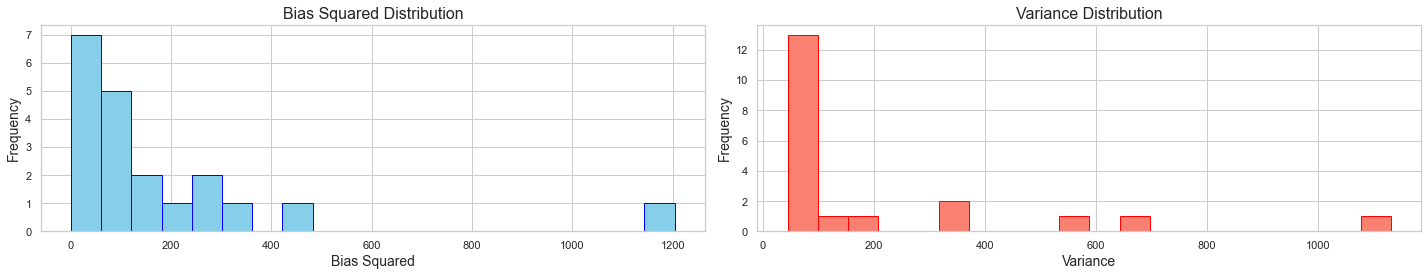

In [23]:
plt.figure(figsize=(20,4))

# Plot the first histogram
plt.subplot(121)
plt.hist(bias_squared_for_each_xi, bins=20, color='skyblue', edgecolor="blue")
plt.title('Bias Squared Distribution', fontsize=16)
plt.xlabel('Bias Squared', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)

# Plot the second histogram
plt.subplot(122)
plt.hist(var_for_each_xi, bins=20, color='salmon', edgecolor="red")
plt.title('Variance Distribution', fontsize=16)
plt.xlabel('Variance', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)

# Adjust layout spacing
plt.tight_layout()

# Show the plot
plt.show()

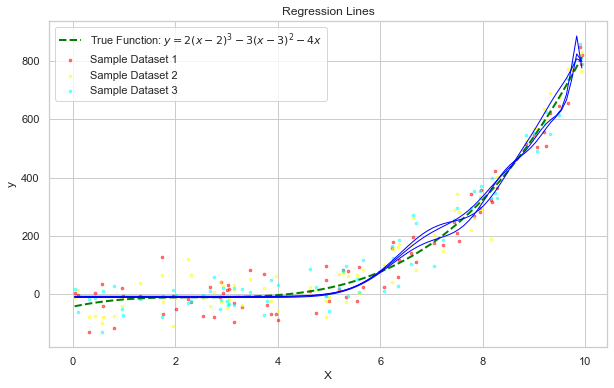

In [24]:
plot_regression_lines(train_samples, models, limit=3, colors=["red", "yellow", "cyan"], 
                      save_path="plots/train_poly_reg_lines.png", featurizer=poly_features)

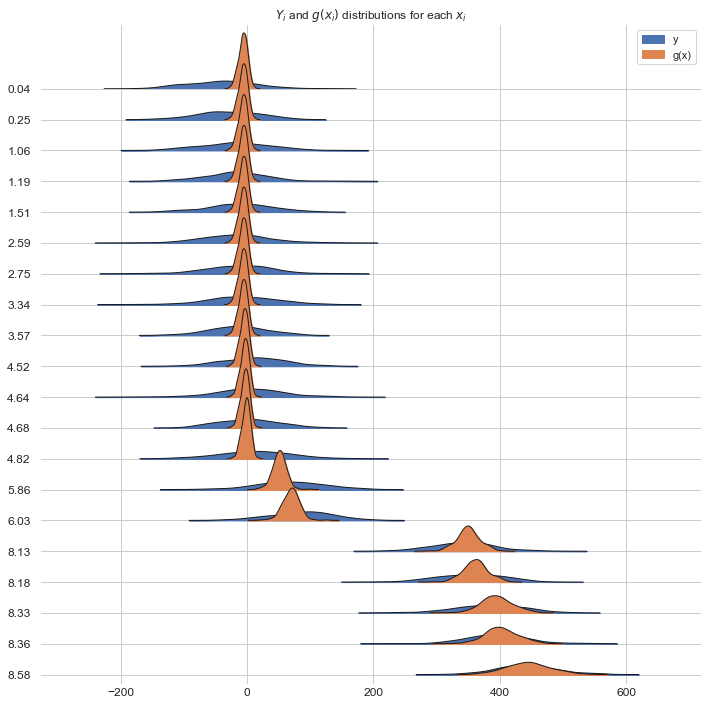

In [25]:
x_matrix = np.expand_dims(np.array(test_samples)[:,:,0], axis=2)
prediction_matrix = np.expand_dims(np.array(test_predictions_across_samples), axis=2)

result_matrix = np.concatenate((x_matrix, prediction_matrix), axis=2)

plot = plot_y_with_gx_distributions_across_samples(np.array(test_samples), result_matrix, 
                                                   save_path="plots/poly_ridge.png")